<a href="https://colab.research.google.com/github/Sahithi102302/Demo/blob/main/DATA_604_Mid_Term_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question-1)

Recall that the principal components form an orthonormal basis for Rd for a suitable value of d. Use Matlab’s ‘pca’ function (or a suitable corresponding function if you are using Python) to obtain principal components for the Fashion MNIST data set as a 784x784 matrix whose columns are the principal compo- nents. Rearrange, the columns, if necessary, so that the they are ordered in the descending order of importance. Let P be the matrix consisting of the principal components as described.

1 (b) From each image class, pick two images at random and draw them as 28 × 28 image. Draw the same images using the representation given by the principal components (i.e. P x for each picture x you pick at random). Address whether the new images resemble the originals.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# Define the transformation to convert images to tensor
transform = transforms.ToTensor()

# Load the Fashion MNIST datasets (train and test)
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Convert train and test datasets to NumPy arrays and flatten the images (28x28 -> 784)
x_train = train_data.data.numpy().reshape(-1, 784)  # Flatten train images (28x28 to 784)
y_train = train_data.targets.numpy()  # Train labels

x_test = test_data.data.numpy().reshape(-1, 784)  # Flatten test images (28x28 to 784)
y_test = test_data.targets.numpy()  # Test labels

# Concatenate the training and test data
full_data = np.concatenate((x_train, x_test), axis=0)  # Combine feature data (images)
full_labels = np.concatenate((y_train, y_test), axis=0)  # Combine label data

# Now x_combined and y_combined represent the entire dataset (train + test)
print(f"Combined Data Shape: {full_data.shape}")
print(f"Combined Labels Shape: {full_labels.shape}")

# Save the combined dataset to a .csv file
df = pd.DataFrame(full_data)
df['labels'] = full_labels
df.to_csv('fashion_mnist_combined.csv', index=False)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.21MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.1MB/s]


Combined Data Shape: (70000, 784)
Combined Labels Shape: (70000,)


In [3]:
# Extract features (X) and labels (y)
X = df.iloc[:, :-1].values  # Feature matrix (images)
y = df['labels'].values  # Labels

1 (c) Pick an optimal number of principal components between 1 and 50 to use in data reduction. Justify your choice regarding the number of components.

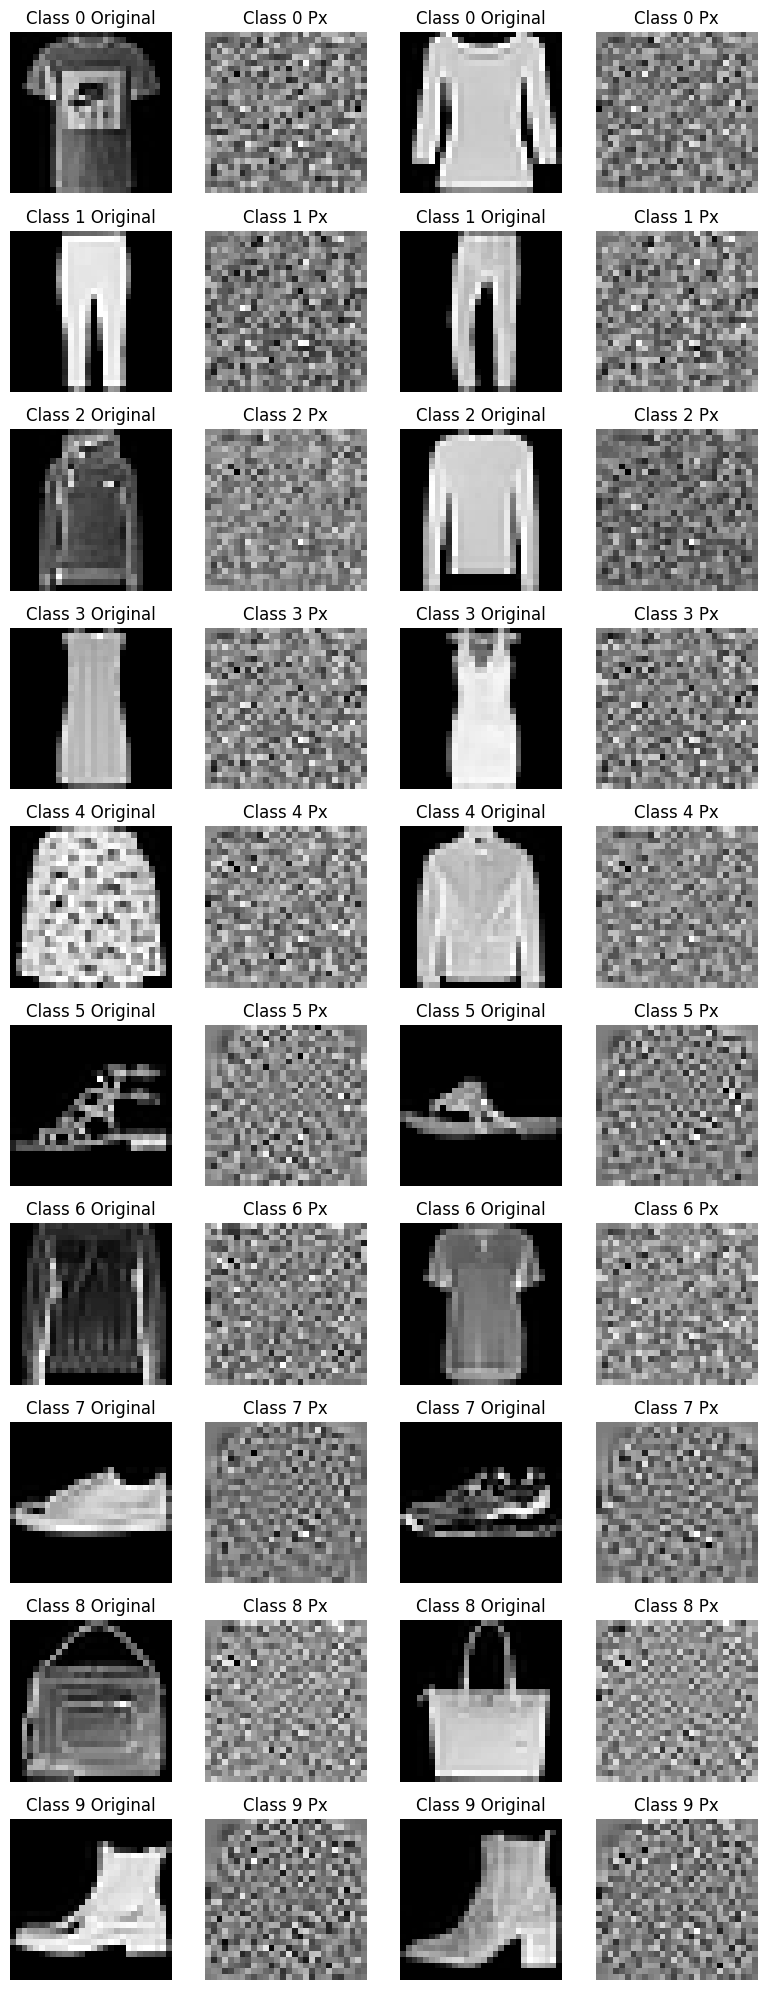

In [4]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=784)
pca.fit(X)
P = pca.components_.T  # 784x784

# Pick 2 random images from each class
fig, axes = plt.subplots(10, 4, figsize=(8, 20))
np.random.seed(42)

for label in range(10):
    class_indices = np.where(full_labels == label)[0]
    selected = np.random.choice(class_indices, 2, replace=False)

    for i, idx in enumerate(selected):
        original = X[idx]
        transformed = P @ original  # T(x) = P x

        # Display original
        axes[label, i*2].imshow(original.reshape(28, 28), cmap='gray')
        axes[label, i*2].set_title(f"Class {label} Original")
        axes[label, i*2].axis('off')

        # Display transformed
        axes[label, i*2+1].imshow(transformed.reshape(28, 28), cmap='gray')
        axes[label, i*2+1].set_title(f"Class {label} Px")
        axes[label, i*2+1].axis('off')

plt.tight_layout()
plt.show()

#### Reconstruction Visualisatiion

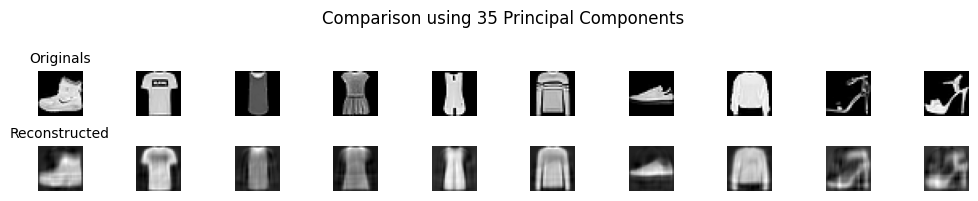

In [5]:
# Reconstruct data using 35 components
pca_opt = PCA(n_components=35)
X_pca_opt = pca_opt.fit_transform(X)
X_reconstructed = pca_opt.inverse_transform(X_pca_opt)

# Compare original and reconstructed images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Originals", fontsize=10)
axes[1, 0].set_title("Reconstructed", fontsize=10)
plt.suptitle("Comparison using 35 Principal Components", fontsize=12)
plt.tight_layout()
plt.show()


Question-2)

Treat the pca representation with the optimal number of components picked above as your new data set. Perform the kNN classification on this new data using k ∈ {5, 10, 15, 20} using the 6000 images from each class in the train set and the last 1000 images from each class in the test set. Report the success rates for each class and the overall accuracy. Does pca help or hurt your classification, i.e. are your results better or worse than when you used the original representation (you can use the corresponding results from your first midterm for comparison if applicable)?

In [6]:
# Apply PCA (reduce from 784 to 35)
pca = PCA(n_components=35)
X_reduced = pca.fit_transform(X)  # Shape: (70000, 35)

# Prepare 6000 train + 1000 test per class
classes = np.unique(full_labels)
X_train, y_train, X_test, y_test = [], [], [], []

for cls in classes:
    class_indices = np.where(full_labels == cls)[0]
    train_idx = class_indices[:6000]
    test_idx = class_indices[-1000:]

    X_train.append(X_reduced[train_idx])
    y_train.append(full_labels[train_idx])
    X_test.append(X_reduced[test_idx])
    y_test.append(full_labels[test_idx])

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_test = np.vstack(X_test)
y_test = np.hstack(y_test)

In [7]:
k_values = [5, 10, 15, 20]

for k in k_values:
    print(f"\n--- k = {k} ---")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Overall accuracy
    overall_acc = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_acc * 100:.2f}%")

    # Per-class accuracy
    for cls in classes:
        cls_mask = (y_test == cls)
        cls_acc = accuracy_score(y_test[cls_mask], y_pred[cls_mask])
        print(f"Class {cls} Accuracy: {cls_acc * 100:.2f}%")


--- k = 5 ---
Overall Accuracy: 85.34%
Class 0 Accuracy: 83.90%
Class 1 Accuracy: 96.40%
Class 2 Accuracy: 77.00%
Class 3 Accuracy: 86.70%
Class 4 Accuracy: 77.30%
Class 5 Accuracy: 89.30%
Class 6 Accuracy: 57.10%
Class 7 Accuracy: 94.40%
Class 8 Accuracy: 95.70%
Class 9 Accuracy: 95.60%

--- k = 10 ---
Overall Accuracy: 85.24%
Class 0 Accuracy: 84.60%
Class 1 Accuracy: 95.80%
Class 2 Accuracy: 77.80%
Class 3 Accuracy: 87.30%
Class 4 Accuracy: 77.20%
Class 5 Accuracy: 89.10%
Class 6 Accuracy: 55.90%
Class 7 Accuracy: 94.00%
Class 8 Accuracy: 95.70%
Class 9 Accuracy: 95.00%

--- k = 15 ---
Overall Accuracy: 85.29%
Class 0 Accuracy: 83.30%
Class 1 Accuracy: 95.60%
Class 2 Accuracy: 77.70%
Class 3 Accuracy: 87.40%
Class 4 Accuracy: 77.00%
Class 5 Accuracy: 87.60%
Class 6 Accuracy: 59.20%
Class 7 Accuracy: 93.60%
Class 8 Accuracy: 95.80%
Class 9 Accuracy: 95.70%

--- k = 20 ---
Overall Accuracy: 85.27%
Class 0 Accuracy: 85.00%
Class 1 Accuracy: 95.60%
Class 2 Accuracy: 77.50%
Class 3 Accu

Question-3)

Treat the pca representation with the optimal number of components picked above as your new data set. Perform multi class classification on this new data using SVM treating the first 6000 images from each class your train set and the last 1000 images from each class as your test set (using One VS Rest). Report the success rates for each class and the overall accuracy. You may use a suitable kernel if you believe it is necessary.

In [8]:
from sklearn.svm import SVC

pca = PCA(n_components=35)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train SVM with RBF kernel (One-vs-Rest is default in SVC)
svm_rbf = SVC(kernel='rbf', decision_function_shape='ovr')
svm_rbf.fit(X_train_pca, y_train)
y_pred = svm_rbf.predict(X_test_pca)

# Overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy * 100:.2f}%")

# Per-class accuracy
report = classification_report(y_test, y_pred, output_dict=True)
for cls in range(10):
    class_acc = report[str(cls)]['recall']
    print(f"Class {cls} Accuracy: {class_acc * 100:.2f}%")


Overall Accuracy: 86.75%
Class 0 Accuracy: 83.80%
Class 1 Accuracy: 95.60%
Class 2 Accuracy: 79.10%
Class 3 Accuracy: 88.60%
Class 4 Accuracy: 79.80%
Class 5 Accuracy: 92.90%
Class 6 Accuracy: 62.20%
Class 7 Accuracy: 93.60%
Class 8 Accuracy: 97.40%
Class 9 Accuracy: 94.50%


In [ ]:
# Define the transformation to convert images to tensor
transform = transforms.ToTensor()

# Load the Fashion MNIST datasets (train and test)
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Convert train and test datasets to NumPy arrays and flatten the images (28x28 -> 784)
x_train = train_data.data.numpy().reshape(-1, 784)  # Flatten train images (28x28 to 784)
y_train = train_data.targets.numpy()  # Train labels

x_test = test_data.data.numpy().reshape(-1, 784)  # Flatten test images (28x28 to 784)
y_test = test_data.targets.numpy()  # Test labels

# Concatenate the training and test data
full_data = np.concatenate((x_train, x_test), axis=0)  # Combine feature data (images)
full_labels = np.concatenate((y_train, y_test), axis=0)  # Combine label data

# Now x_combined and y_combined represent the entire dataset (train + test)
print(f"Combined Data Shape: {full_data.shape}")
print(f"Combined Labels Shape: {full_labels.shape}")

# Save the combined dataset to a .csv file
df = pd.DataFrame(full_data)
df['labels'] = full_labels
df.to_csv('fashion_mnist_combined.csv', index=False)